# Basic tutorial
We'll start with a simple tutorial that shows how to use the basic functionality of abcd-graph.

In [1]:
from abcd_graph import ABCDGraph, ABCDParams
from abcd_graph.utils import seed
seed(42)

We will start by building a graph with the default parameters.

In [2]:
G = ABCDGraph()
G.build()
print(G.params)

ABCDParams(vcount=1000, gamma=2.5, beta=1.5, xi=0.25, min_degree=5, max_degree=30, min_community_size=20, max_community_size=250, num_outliers=0)


In many cases, we simply need the edges and membership list.

In [3]:
E = G.edges
ml = G.membership_list
print("first 5 edges:", E[:5])
print("community label containing vertex 299: ", ml[299])

first 5 edges: [(975, 238), (764, 139), (346, 335), (625, 229), (766, 93)]
community label containing vertex 299:  1


Each community in G is its own object.

In [4]:
C = G.communities[1]
print(C)

ABCDCommunityObj(id=1, vertices=197-338)


We can export G as an adjacency matrix or as a sparse adjacency matrix.

In [5]:
import numpy as np
import scipy as sp

M = G.exporter.to_adjacency_matrix()
M_sparse = G.exporter.to_sparse_adjacency_matrix()
print(type(M))
print(M[0][20:30],'\n')
print(type(M_sparse))
print(M_sparse[0])

<class 'numpy.ndarray'>
[False False  True False False False False False False  True] 

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 22)	True
  (0, 29)	True
  (0, 77)	True
  (0, 92)	True
  (0, 124)	True
  (0, 133)	True
  (0, 163)	True


We can also export G to igraph and to networkx. 

In [6]:
import igraph as ig
import networkx as nx

In [7]:
G_ig = G.exporter.to_igraph()
print(G_ig.vs[299]['ground_truth_community'])

1


In [8]:
G_nx = G.exporter.to_networkx()
print(G_nx.nodes[299]['ground_truth_community'])

1


Finally, the newest version of abcd-graph allows us to add outliers to the graph. The current id for the outliers is -1, and this "community" is always listed at the end of G.communities. 

In [9]:
params = ABCDParams(num_outliers=100)
G = ABCDGraph(params)
G.build()
print(G.communities[-1])

ABCDCommunityObj(id=-1, vertices=900-999)


# In depth tutorial

Here we will show the full functionality of abcd-graph. Note that this section can be compiled without needing to compile the above code first.

In [10]:
from abcd_graph import ABCDGraph, ABCDParams
from abcd_graph.callbacks import PropertyCollector, StatsCollector, Visualizer
from abcd_graph.utils import seed

We will build an ABCD graph with specified parameters and callbacks to reference later. A concise description of the parameters (aside from outliers) can be found in Section 2.3 [here](https://math.ryerson.ca/~pralat/papers/2022_modularity-abcd.pdf), and the addition of outliers is explained [here](https://math.ryerson.ca/~pralat/papers/2023_ABCD-outliers-CN2022.pdf). 

NOTE: PropertyCollector() is currently very slow and should not be included in the callbacks if your graph has more than a few thousand vertices. 

In [11]:
seed(42)
stats = StatsCollector()
props = PropertyCollector()
vis = Visualizer()

params = ABCDParams(
    vcount=100, 
    gamma=2.8,
    min_degree=3,
    max_degree=15,
    beta=1.6,
    min_community_size=10,
    max_community_size=40,
    xi=0.15,
    num_outliers=10,
)
G = ABCDGraph(params, callbacks = [stats, props, vis])
G.build()
G.communities

[ABCDCommunityObj(id=0, vertices=0-24),
 ABCDCommunityObj(id=1, vertices=25-47),
 ABCDCommunityObj(id=2, vertices=48-65),
 ABCDCommunityObj(id=3, vertices=66-78),
 ABCDCommunityObj(id=4, vertices=79-89),
 ABCDCommunityObj(id=-1, vertices=90-99)]

# Statistics

We use StatsCollector().statistics to obtain the a dictionary of statistics for our ABCD graph.

In [12]:
stats.statistics

{'model_used': 'configuration_model',
 'params': ABCDParams(vcount=100, gamma=2.8, beta=1.6, xi=0.15, min_degree=3, max_degree=15, min_community_size=10, max_community_size=40, num_outliers=10),
 'number_of_nodes': 100,
 'start_time': datetime.datetime(2024, 11, 19, 19, 44, 6, 692592),
 'end_time': datetime.datetime(2024, 11, 19, 19, 44, 6, 696161),
 'time_to_build': 0.0035318806767463684,
 'number_of_edges': 226,
 'number_of_communities': 5,
 'expected_average_degree': 4.581006406463586,
 'actual_average_degree': 4.52,
 'expected_average_community_size': 19.289280872961996,
 'actual_average_community_size': 18.0,
 'number_of_loops': 11,
 'number_of_multi_edges': 18,
 'empirical_xi': 0.23451327433628322}

# Properties

We use PropertyCollector() to obtain the various properties of our ABCD graph. 

In [13]:
d_seq = props.degree_sequence
d_min = min(d_seq.values())
d_max = max(d_seq.values())
num_min = len([i for i in d_seq if d_seq[i] == d_min])
num_max = len([i for i in d_seq if d_seq[i] == d_max])
print("The minimum degree is",d_min,"and",num_min,"vertices have this degree.")
print("The maximum degree is",d_max,"and",num_max,"vertices have this degree.")

The minimum degree is 3 and 50 vertices have this degree.
The maximum degree is 14 and 1 vertices have this degree.


We can also get the xi-matrix here. In this matrix, cell (i, j) is the number of edges between community i and community j, normalized by the expected number. This is also the case when i = j, i.e., cell (i, i) is the number of edges within community i, normalized by the expected number. 

In theory, all diagonal cells should be very close to 1 (with the exception of the bottom right cell representing outliers) and the remaining cells should resemble samples from a normalized binomial distribution. 

In [14]:
M_xi = props.xi_matrix
print(M_xi)

[[0.97560976 0.54761905 1.36904762 1.82539683 0.         1.25496032]
 [0.54761905 1.03967168 1.15       1.91666667 1.04545455 1.19791667]
 [1.36904762 1.15       0.94579008 1.91666667 1.04545455 0.83854167]
 [1.82539683 1.91666667 1.91666667 1.0230179  0.         0.39930556]
 [0.         1.04545455 1.04545455 0.         0.90112641 1.30681818]
 [1.25496032 1.19791667 0.83854167 0.39930556 1.30681818 0.8984375 ]]


Finally, we can find the CDFs for the degree sequence and community size sequence here. We will address these in the next section.

# Visualization

For n <= 100, we offer a quick drawing tool for our ABCD graph. The outliers in this case are yellow and labelled from 90 to 99

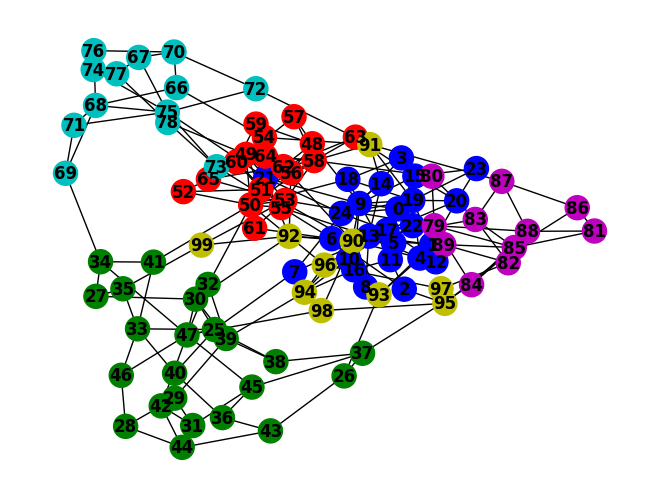

In [15]:
vis.draw_communities()

We can also draw the CDFs for both the degree sequence and the communitiy size sequence. In both cases, the actual CDFs are compared with the theoretical CDFs.

NOTE: draw_community_cdf() is currently broken.

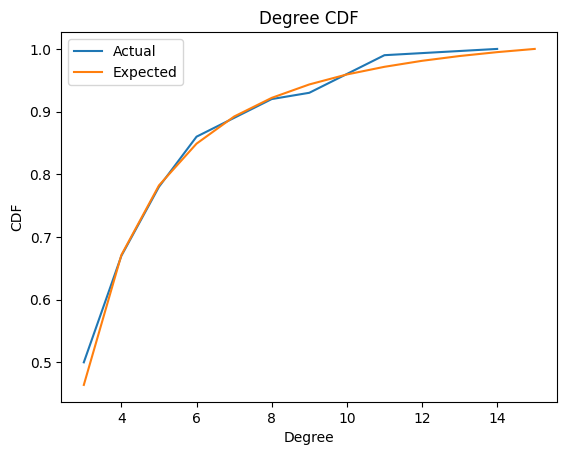

In [16]:
vis.draw_degree_cdf()
#vis.draw_community_cdf()

# Parameters and speed

The speed of the ABCD construction process is highly dependent on the number of loops and multi-edges generated, since each of these collisions needs to be rewired. As a rule of thumb, smaller gamma and larger min_degree imply a longer build time. 

In [17]:
g_list = [2.1, 2.5, 2.9]
for gamma in g_list:
    params = ABCDParams(vcount=100_000, gamma=gamma)
    G = ABCDGraph(params=params, callbacks=[stats]).build()
    print('gamma = ',gamma)
    print('number of collisions = ',stats.statistics['number_of_loops']+stats.statistics['number_of_multi_edges'])
    print('time_to_build = ',stats.statistics['time_to_build'],'\n')

gamma =  2.1
number of collisions =  31274
time_to_build =  3.404880713671446 

gamma =  2.5
number of collisions =  25539
time_to_build =  2.848343100398779 

gamma =  2.9
number of collisions =  19381
time_to_build =  2.2153489515185356 



In [20]:
min_degree_list = [2, 5, 8]
for min_degree in min_degree_list:
    params = ABCDParams(vcount=100_000, min_degree=min_degree)
    G = ABCDGraph(params=params, callbacks=[stats]).build()
    print('min_degree = ',min_degree)
    print('number of collisions = ',stats.statistics['number_of_loops']+stats.statistics['number_of_multi_edges'])
    print('time_to_build = ',stats.statistics['time_to_build'],'\n')

min_degree =  2
number of collisions =  8224
time_to_build =  1.545698158442974 

min_degree =  5
number of collisions =  25245
time_to_build =  2.839053586125374 

min_degree =  8
number of collisions =  42299
time_to_build =  4.214963003993034 

